In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")

In [3]:
path = os.getcwd()

In [4]:
df = pd.read_csv(path + str('/daily-minimum-temperatures.csv'), parse_dates = True)

In [5]:
df.dtypes

Date     object
Temp    float64
dtype: object

In [6]:
df.shape

(3650, 2)

In [7]:
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [8]:
df['Date'] = pd.to_datetime(df.Date)

In [9]:
df.dtypes

Date    datetime64[ns]
Temp           float64
dtype: object

In [10]:
df.Date.dt.year.head()

0    1981
1    1981
2    1981
3    1981
4    1981
Name: Date, dtype: int64

In [11]:
df.Date.dt.day.head()

0    1
1    2
2    3
3    4
4    5
Name: Date, dtype: int64

In [12]:
# 0 starts with monday....# 5, 6 are weekends
df.Date.dt.dayofweek.head()

0    3
1    4
2    5
3    6
4    0
Name: Date, dtype: int64

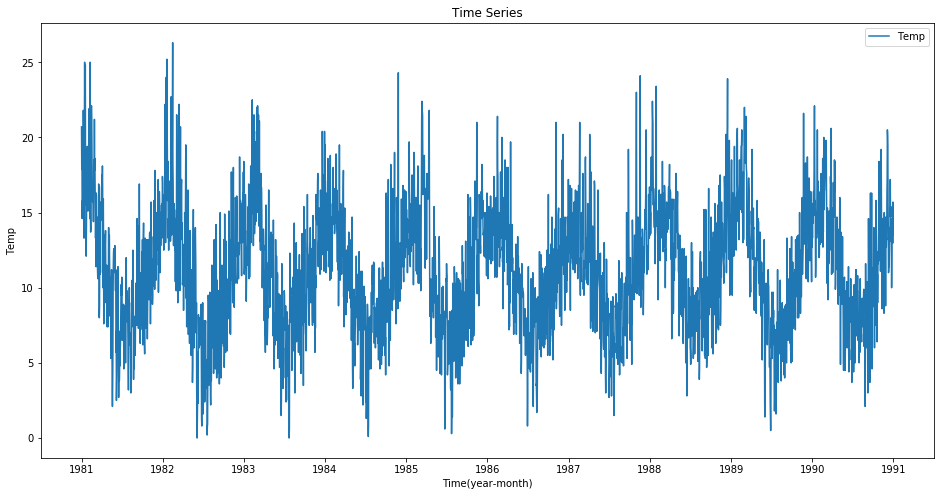

In [13]:
df.index = df['Date']
plt.figure(figsize=(16,8))
plt.plot(df['Temp'])
plt.title('Time Series')
plt.xlabel("Time(year-month)")
plt.ylabel("Temp")
plt.legend(loc='best')

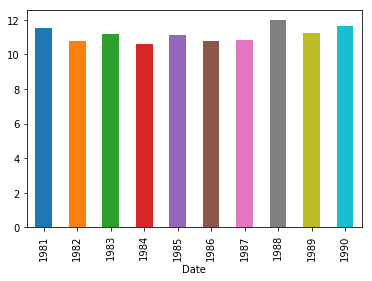

In [14]:
df.groupby(df.Date.dt.year)['Temp'].mean().plot.bar()

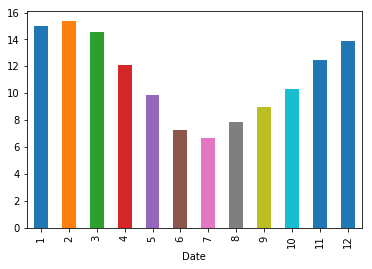

In [15]:
df.groupby(df.Date.dt.month)['Temp'].mean().plot.bar()

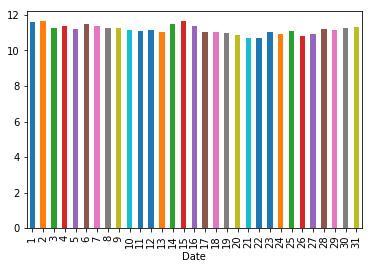

In [16]:
df.groupby(df.Date.dt.day)['Temp'].mean().plot.bar()

In [17]:
# Converting to daily mean
daily = df['Temp'].resample('D').mean()

# Converting to weekly mean
weekly = df['Temp'].resample('W').mean()

# Converting to monthly mean
monthly = df['Temp'].resample('M').mean()

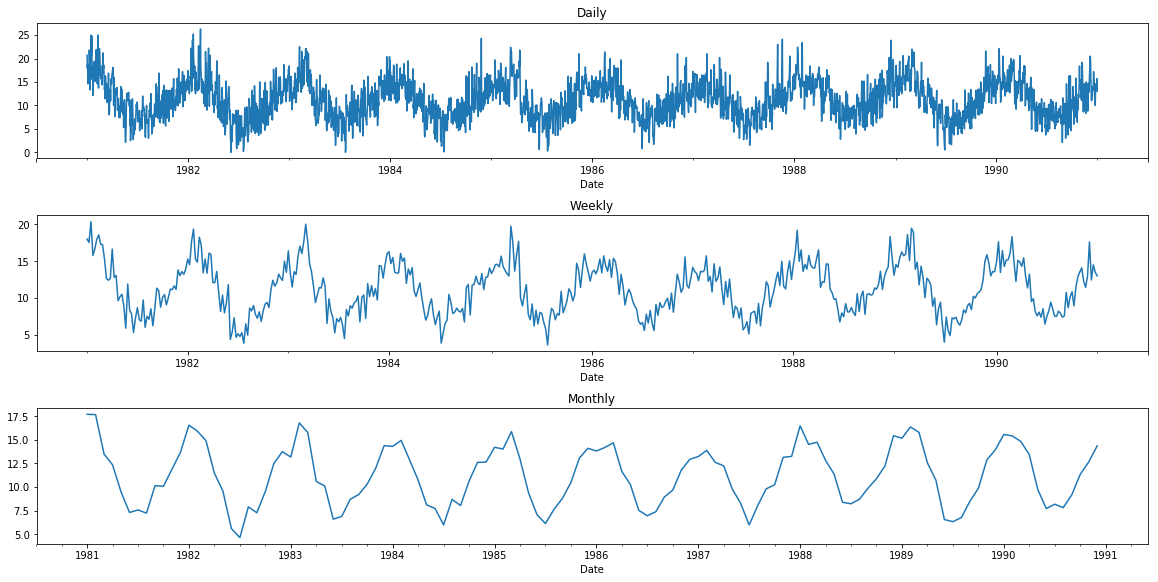

In [18]:
%matplotlib inline

fig, axs = plt.subplots(3,1)

daily.plot(figsize=(16,8), title= 'Daily', ax=axs[0])
weekly.plot(figsize=(16,8), title= 'Weekly',ax=axs[1])
monthly.plot(figsize=(16,8), title= 'Monthly',ax=axs[2])

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

In [19]:
# removing trend and Seasonality

In [20]:
# moving_avg = df['Temp'].rolling(12).mean()
# plt.figure(figsize=(16,8))
# plt.plot(df['Temp'])
# plt.plot(moving_avg, color = 'red')
# plt.show()

In [21]:
from statsmodels.tsa.stattools import adfuller

#Perform Dickey-Fuller test:

dftest = adfuller(df['Temp'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                   -4.444805
p-value                           0.000247
Lags Used                        20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


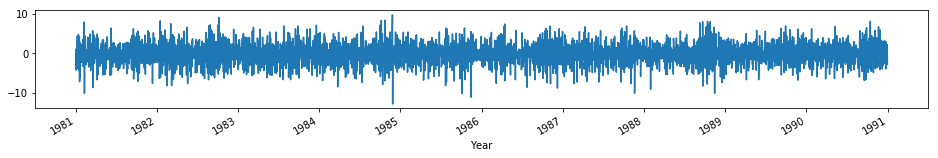

In [22]:
df['Temp'].diff().plot(figsize=(16,2))
plt.xlabel('Year');

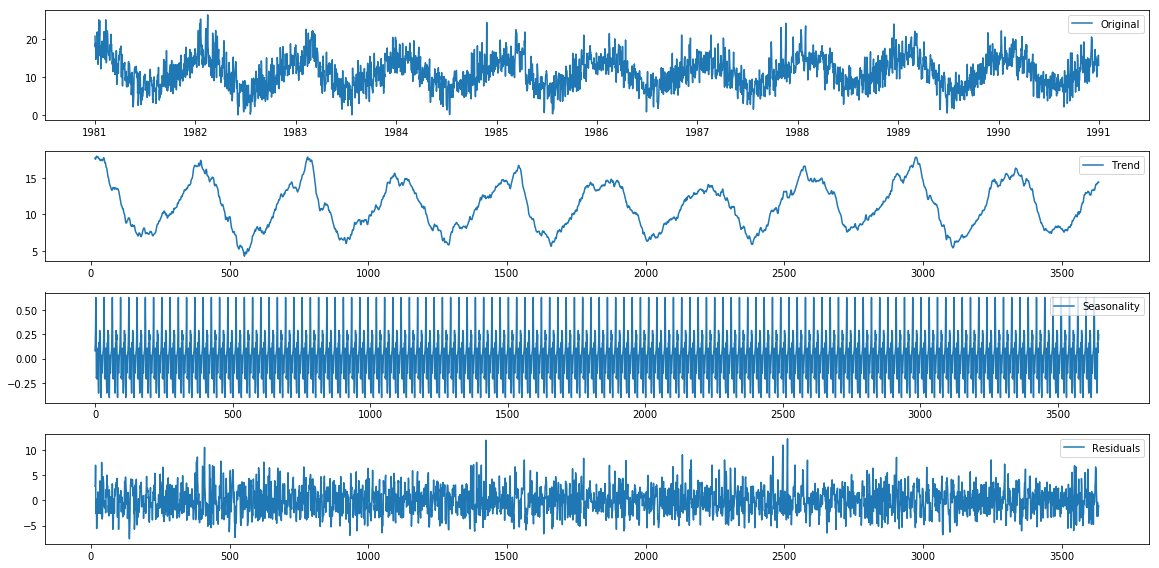

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df.Temp.values, freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize = (16,8))
plt.subplot(411)
plt.plot(df['Temp'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

The predictors depend on the parameters (p,d,q) of the ARIMA model:

1. Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. 
For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
2. Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. 
For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
3. Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the 
first order difference. So either we can pass that variable and put d=0 or pass the original variable and 
put d=1. Both will generate same results.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

1. Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).

2. Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.
The ACF and PACF plots for the TS after differencing can be plotted as:

In [24]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(df.Temp, nlags=20)
lag_pacf = pacf(df.Temp, nlags=20, method='ols')

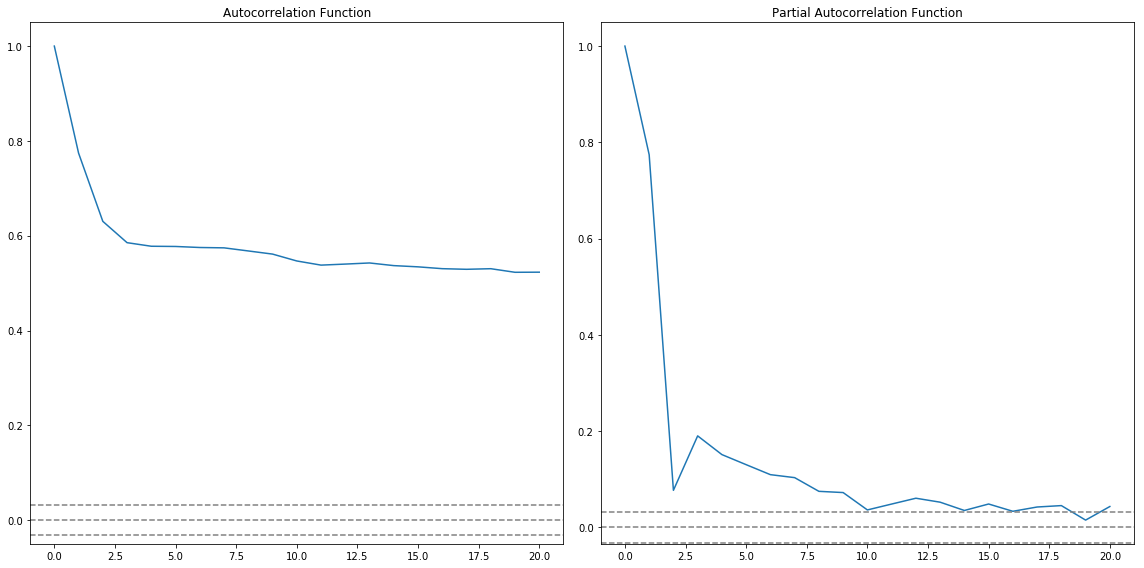

In [80]:
#Plot ACF:
plt.figure(figsize = (16, 8))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df.Temp)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df.Temp)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df.Temp)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df.Temp)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

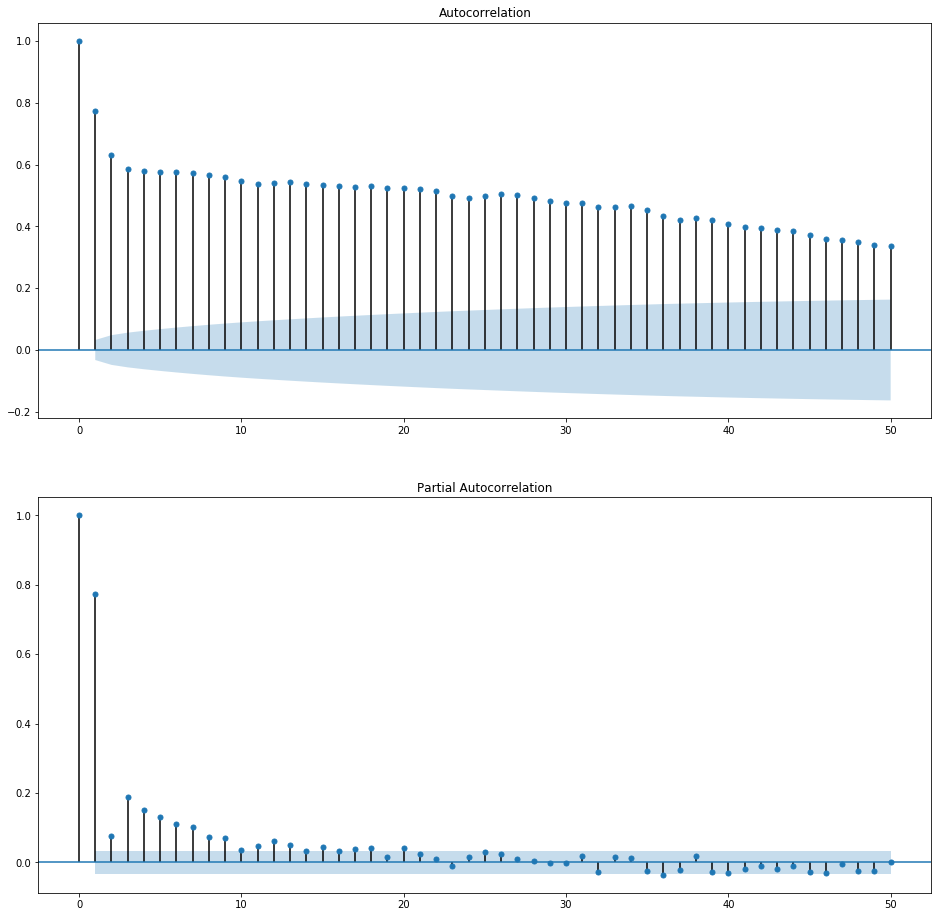

In [28]:
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

series = df.Temp
plt.figure(figsize = (16,16))
plt.subplot(211)
plot_acf(series, lags=50, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, lags=50, ax=plt.gca())
plt.show()